In [1]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Pakete

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy.stats
#from scipy.stats import wilcoxon
import time
import shap
import xgboost
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Optimale Parameter
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#SVM
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib import cm

from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Interpretation
import shap
shap.initjs()


In [2]:

# testdaten für die presi holen
import os
os.getcwd()
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

df = pd.read_csv('data/aidsenc.csv', sep =",")

In [3]:
df.shape

(2139, 17)

In [4]:
df.columns

Index(['Unnamed: 0', 'age', 'cd40', 'cid', 'trt_1', 'trt_2', 'trt_3', 'homo_1',
       'drugs_1', 'z30_1', 'gender_1', 'strat_2', 'strat_3', 'symptom_1',
       'hemo_1', 'race_1', 'ecog_1'],
      dtype='object')

In [5]:
# für weitere Tables 'Unnamed' Nummerierung enfernen
df = df.drop(["Unnamed: 0"],axis=1) #,"hemo", "race", "ecog"

In [6]:
df.head(5)

,age,cd40,cid,trt_1,trt_2,trt_3,homo_1,drugs_1,z30_1,gender_1,strat_2,strat_3,symptom_1,hemo_1,race_1,ecog_1
0,48,422,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,61,162,1,0,0,1,0,0,1,0,0,1,0,0,0,0
2,45,326,0,0,0,1,1,1,1,1,0,1,0,0,0,0
3,47,287,0,0,0,1,1,0,1,1,0,1,0,0,0,0
4,43,504,0,0,0,0,1,0,1,1,0,1,0,0,0,0


In [7]:
# df1-Datensatz für erste Modellrechnungen erstellen, der unveränderter, encodeder df-Datensatz kann im Verlauf aufgerufen werden
df1 = df

# Datensplitting Testdaten

In [8]:
X=df1.drop(['cid'],axis=1)
y=df1['cid']

In [9]:
# die finalen Testdaten für das Modell
X_fintrain, X_fintest, y_fintrain, y_fintest = train_test_split(X, y, shuffle=True, test_size=0.2,random_state=42)

print('X Train groß: {}'.format(X_fintrain.shape)) 
print('Y Train groß: {}'.format(y_fintrain.shape)) 
print('X Test final: {}'.format(X_fintest.shape)) 
print('Y Test final: {}'.format(y_fintest.shape))


X Train groß: (1711, 15)
Y Train groß: (1711,)
X Test final: (428, 15)
Y Test final: (428,)


# Erstellen des Validierungsdatensatzes

Der Trainingsdatensatz wird noch ein mal geteilt, um während der Trainingsphase einen Validierungsdatensatz zu haben.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_fintrain, y_fintrain, shuffle=True, test_size=0.2,random_state=42)

print('X Train klein: {}'.format(X_train.shape)) 
print('Y Train klein: {}'.format(y_train.shape)) 
print('X Validierung: {}'.format(X_test.shape)) 
print('Y Validierung: {}'.format(y_test.shape))

X Train klein: (1368, 15)
Y Train klein: (1368,)
X Validierung: (343, 15)
Y Validierung: (343,)


In [11]:
# Trainingsdaten bereitstellen
X_train1 = X_train.copy()
X_test1 = X_test.copy()
y_train1 = y_train.copy()
y_test1 = y_test.copy()

# Transformierung mit MinMaxScaler

Die Entscheidung für die Normalisierung (und nicht die Standardisierung) wurde in Anbetracht der Ungewissheit, wie die unbekannten, neuen Test-Daten verteilt werden würden, getroffen.

Es werden nur die Daten für das Training normalisiert. 

## Scaler fitten

Das ist zugegeben eine unschöne Lösung. Der Scaler wird auf den Daten 1. Splits gefittet und die numerischen Features gleich transformiert.
Schöner wäre es, den Scaler auf numerische Features zu fitten und über pipelines beliebeg auf Daten mit scaler.transform() anwenden. 

In [12]:
#from sklearn.preprocessing import MinMaxScaler
mscaler = MinMaxScaler()

X_train1['age'] = mscaler.fit_transform(X_train1['age'].to_numpy().reshape(-1,1))
X_train1['cd40'] = mscaler.fit_transform(X_train1['cd40'].to_numpy().reshape(-1,1))

X_test1['age'] = mscaler.fit_transform(X_test1['age'].to_numpy().reshape(-1,1))
X_test1['cd40'] = mscaler.fit_transform(X_test1['cd40'].to_numpy().reshape(-1,1))

# Hyperparameter

Die Suche nach optimalen `C`, `gamma`, `kernel`, `max_depth` und `n_estimators` wurde mittels `RandomizedSearch` durchgeführt. GRID-Research dauerte zu lange. 

Per default ist Gamma 'scale', i.e. gamma = 1 / (n_features * X.var()). <span style=color:green>Vorweg:</span> Es wird überlegt, die `gamma`='scale' statt dem optimierten wert zu nehmen. Dennoch wird der `gamma` erst ein Mal über `RandomizedSearch` ermittelt und angeschaut.

<span style=color:green>Nota bene:</span>

`C` (Regularization Parameter): Controls the trade-off between a smooth decision boundary and correctly classifying training points.

`Kernel`: Specifies the function that transforms the input data into a higher-dimensional space to make it linearly separable.

`Gamma (γ)`: Determines how far the influence of a single training example reaches in non-linear kernels like RBF.

Die Doku vom [sklearn.model_selection](https://scikit-learn.org/stable/api/sklearn.model_selection.html).

Die Hyperparameter-Optimierung und Modellbetrachtung erfolgt auf kleineren Trainingsdaten.

In [13]:

# für LogReg

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=42)
search = clf.fit(X_train1, y_train1)

print("Die optimalen Hyperparameter für LogReg (Random Search):", search.best_params_)

Die optimalen Hyperparameter für LogReg (Random Search): {'C': np.float64(0.23233444867279784), 'penalty': 'l1'}


In [14]:
# für SVM
param_dist = {
    'C': uniform(loc=0, scale=4),   #[0.1,1,10,100,1000]
    'gamma': [1,0.1,0.01,0.001,0.0001],
    'kernel': ['rbf', 'linear'] # Beschrenkung auf die zwei Kernel, weil die Daten relativ gut strukturiert sind
}

random_search0 = RandomizedSearchCV(SVC(random_state=42), param_dist, n_iter=10, refit=True,cv=10,verbose=0,random_state=42) #verbose = 0 : keine einzeln. Messages zu den fits
random_search0.fit(X_train1,y_train1)

print("Die optimalen Hyperparameter für SVM (Random Seaarch):", random_search0.best_params_)


Die optimalen Hyperparameter für SVM (Random Seaarch): {'C': np.float64(1.49816047538945), 'gamma': 0.0001, 'kernel': 'rbf'}


In [15]:
# für RF
param_dist = {'n_estimators': randint(10,300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search0 = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=10, random_state=42)

# Fit the random search object to the data
rand_search0.fit(X_train1, y_train1)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000187E9ABFDF0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000187E9A8F700>},
                   random_state=42)

In [16]:
best_rf0 = rand_search0.best_estimator_

# Print the best hyperparameters
print('Die optimalen Hyperparameter für RF (Random Search):',  rand_search0.best_params_)

Die optimalen Hyperparameter für RF (Random Search): {'max_depth': 7, 'n_estimators': 280}


# Die Auswahl des Classifikators

In [17]:
n_features = X.shape[1]

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(C=0.2, penalty="l1", solver="saga", max_iter=10000, random_state=42),
    
    "RBF SVC": SVC(kernel="rbf", C=1.5, gamma=0.0001, random_state=42),
    
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=131, random_state=42)
}

for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y_pred0 = classifier.fit(X_train1, y_train1).predict(X_test1)
    accuracy0 = accuracy_score(y_test1, y_pred0)
    precision0 = precision_score(y_test1, y_pred0)
    recall0 = recall_score(y_test1, y_pred0)
    
    print(f"Trainingsdaten, Akkuranz für {name}: {accuracy0:0.2%}")
    print(f"Trainingsdaten, Precision für {name}: {precision0:0.2%}")
    print(f"Trainingsdaten, Recall für {name}: {recall0:0.2%}")
    
for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    accuracy01 = classifier.score(X_train1,y_train1)
    accuracy02 = classifier.score(X_test1,y_test1)
    
    print(f"Accuracy Differenz Train-Test für {name}: {accuracy01-accuracy02:3f}")
    

Trainingsdaten, Akkuranz für L1 logistic: 74.05%
Trainingsdaten, Precision für L1 logistic: 50.00%
Trainingsdaten, Recall für L1 logistic: 2.25%
Trainingsdaten, Akkuranz für RBF SVC: 74.05%
Trainingsdaten, Precision für RBF SVC: 0.00%
Trainingsdaten, Recall für RBF SVC: 0.00%
Trainingsdaten, Akkuranz für Random Forest: 74.34%
Trainingsdaten, Precision für Random Forest: 57.14%
Trainingsdaten, Recall für Random Forest: 4.49%
Accuracy Differenz Train-Test für L1 logistic: 0.024826
Accuracy Differenz Train-Test für RBF SVC: 0.017516
Accuracy Differenz Train-Test für Random Forest: 0.078928


### gamma = 'scale'

In [18]:
# mit gamma = 'scale'
n_features = X.shape[1]

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(C=0.2, penalty="l1", solver="saga", max_iter=10000, random_state=42),
    
    "RBF SVC": SVC(kernel="rbf", C=1.5, gamma="scale", random_state=42),
    
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=131, random_state=42)
}

for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y_pred1 = classifier.fit(X_train1, y_train1).predict(X_test1)
    accuracy1 = accuracy_score(y_test1, y_pred1)
    precision1 = precision_score(y_test1, y_pred1)
    recall1 = recall_score(y_test1, y_pred1)
    
    print(f"Trainingsdaten, Akkuranz für {name}: {accuracy1:0.2%}")
    print(f"Trainingsdaten, Precision für {name}: {precision1:0.2%}")
    print(f"Trainingsdaten, Recall für {name}: {recall1:0.2%}")
    
for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    accuracy01 = classifier.score(X_train1,y_train1)
    accuracy02 = classifier.score(X_test1,y_test1)
    
    print(f"Accuracy Differenz Train-Test für {name}: {accuracy01-accuracy02:3f}")
    

Trainingsdaten, Akkuranz für L1 logistic: 74.05%
Trainingsdaten, Precision für L1 logistic: 50.00%
Trainingsdaten, Recall für L1 logistic: 2.25%
Trainingsdaten, Akkuranz für RBF SVC: 73.76%
Trainingsdaten, Precision für RBF SVC: 42.86%
Trainingsdaten, Recall für RBF SVC: 3.37%
Trainingsdaten, Akkuranz für Random Forest: 74.34%
Trainingsdaten, Precision für Random Forest: 57.14%
Trainingsdaten, Recall für Random Forest: 4.49%
Accuracy Differenz Train-Test für L1 logistic: 0.024826
Accuracy Differenz Train-Test für RBF SVC: 0.043823
Accuracy Differenz Train-Test für Random Forest: 0.078928


Die Entscheidung bei RBF-SVC wäre für `gamma`= 'scale'. Allerdings wäre der beste Calssifikator - anhand von Performance-Parameter - der Random Forest. So wäre `gamma` nicht weiter wichtig. Auch `Precision` und `Recall` sprechen für Random Forest.

Die Akkuranz-Differenz zeigt allerdings, dass Random Forest Modell ggf. zum **Overfit** neigt. Bei *LogReg* ist die Akkuranz-Differenz am geringsten.

<span style=color:green>Entscheidung:</span> *Random Forest* UND *LogReg* auf permutation importance anschauen. 

Die *permutation importance* gibt Auskunft darüber, wie wichtig das jeweilige Feature für genau dieses Modell ist.==> ggf. Die Daten noch ein Mal reduzieren.

# Logistische Regression und Random Forest

*classification_report* fasst die Performance-Parameter des Modells im Bezug auf das Target zusammen.

In [19]:
search.best_estimator_

LogisticRegression(C=np.float64(0.23233444867279784), max_iter=200,
                   penalty='l1', random_state=0, solver='saga', tol=0.01)

LogReg               precision    recall  f1-score   support

           0       0.99      0.74      0.85       339
           1       0.02      0.50      0.04         4

    accuracy                           0.74       343
   macro avg       0.51      0.62      0.45       343
weighted avg       0.98      0.74      0.84       343

Random Forest               precision    recall  f1-score   support

           0       0.98      0.74      0.85       336
           1       0.03      0.43      0.06         7

    accuracy                           0.74       343
   macro avg       0.51      0.59      0.45       343
weighted avg       0.96      0.74      0.83       343



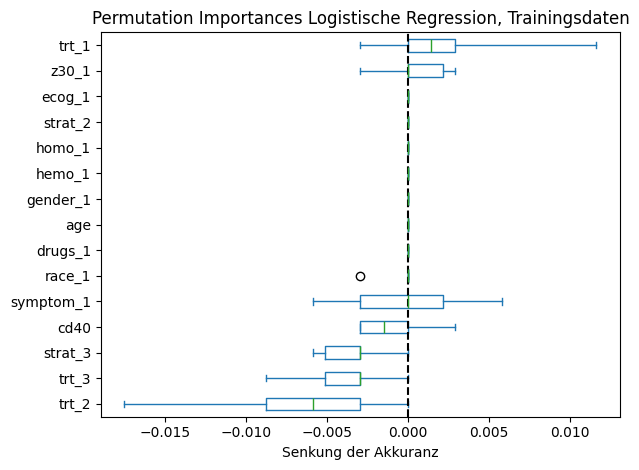

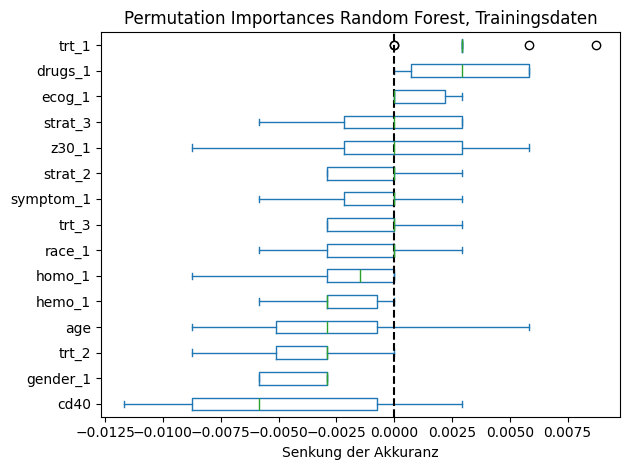

In [20]:
from sklearn.metrics import classification_report

best_logreg = search.best_estimator_

best_logreg.fit(X_train1, y_train1)
y_pred21 = best_logreg.predict(X_test1)
accuracy21 = accuracy_score(y_test1, y_pred21)
print("LogReg",classification_report(y_pred21, y_test1))


best_rf0.fit(X_train1, y_train1)
y_pred22 = best_rf0.predict(X_test1)
accuracy22 = accuracy_score(y_test1, y_pred22)
#print("Trenningsdaten, Akkuranz RF Modell:", accuracy2)
print("Random Forest", classification_report(y_pred22, y_test1))
######


perm_logreg_train = permutation_importance(best_logreg, X_test1, y_test1, random_state=42, n_repeats=10, n_jobs=2)

feature_names1 = X_train1.columns
features = np.array(feature_names1)

sorted_importances_idx = perm_logreg_train.importances_mean.argsort()
importances1 = pd.DataFrame(
    perm_logreg_train.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances1.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances Logistische Regression, Trainingsdaten")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Senkung der Akkuranz")
ax.figure.tight_layout()

#####
perm_rf_train = permutation_importance(best_rf0, X_test1, y_test1, random_state=42, n_repeats=10, n_jobs=2)

feature_names1 = X_train1.columns
features = np.array(feature_names1)

sorted_importances_idx = perm_rf_train.importances_mean.argsort()
importances2 = pd.DataFrame(
    perm_rf_train.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances2.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances Random Forest, Trainingsdaten")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Senkung der Akkuranz")
ax.figure.tight_layout()

A negative coefficient means that higher value of the corresponding feature pushes the classification more towards the negative class. 

Die *Precision* für Target = 1 ist in beiden Modellen mau. *F1-Score* (Zusammenfassung von Precision und Recall) ist für *Random Forest* **geringfügig** besser. Das alles ist ein Hinweis auf stark assymetrische Daten, was ja auch das Preprocessing andeutet. Hier wäre ein Schritt zurück zum Preprocessing angebracht, um nicht nur Visualisierungen, sondern auch ggf. *p-values* für die Features zu errechnen. Im Rahmen dieser Arbeit wird dieser Schritt nicht gemacht.

<span style=color:red>Das Overfit:</span>
*Permutation importance* von LogReg unterstützt das *domain*-Wissen über die Auswirkung von Prediktoren auf das Outcome. `Symptome`, `immunologischer Marker`, `das eigentliche Treatment` und vorige `Therapien` können eher Einfluss auf das Überleben mit HIV ausüben. 

Wenn bei *Random Forest* fast alle Features einen EInfluss auf das Modell zu haben scheinen, wäre dies ein Hinweis auf das schon oben gesichtete **Overfit**. 

Zwischenfazit:

Das Log-Regression Modell händelt die vorhandenen Daten stimmiger. Daher wird das Aussortieren der unwichtigen Features anhand von *permutation importance* von LogReg vorgenommen. Trotz der geringfügig kleinerer Akkuranz gegenüber dem Random Forest fällt die Enscheidung für die *Logistische Regression*.  Das passende Fitting des Modells ist wichtiger als wenige Zehntel Prozentpunkte Verlust der Akkuranz.



<span style=color:green> Die möglichen 'low-perform' Features</span> wären nun `ecog`, `homo`, `hemo`, `gender`, `drugs`, `race` und `age`. 

Bevor wir zu dem nächsten Schritt unwichtige Features auszusortiren übergehen, werden hier unten noch ein Mal *Precision* und *Recall* in einer *Confusionsmatrix* dargestellt. So springt die mittelmässige Leistung der Modelle noch besser ins Auge. 

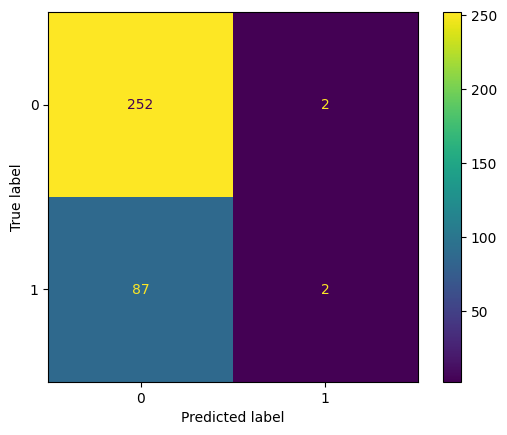

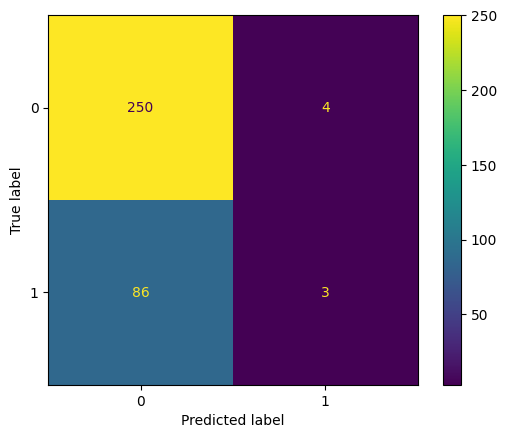

In [21]:
# Log Reg auf Trainingsdaten
cm0 = confusion_matrix(y_test1, y_pred21)
ConfusionMatrixDisplay(cm0).plot();

# Random Forest auf Trainingsdaten
cm1 = confusion_matrix(y_test1, y_pred22)
ConfusionMatrixDisplay(cm1).plot();



# Feature-Reduktion

Nachfolgend werden die Features anhand von *feature permutation* für das LogReg Modell und nach inhaltlichen Überlegungen (domain Wissen) aus der weiteren Modellierung entfernt:

`ecog`, `homo`, `hemo`, `gender`, `drugs`, `race` und `age`.

In [22]:
# Reduzierter Datensatz 
X_train2=X_train.drop(['age', 'homo_1', 'drugs_1', 'gender_1', 'hemo_1', 'race_1', 'ecog_1'],axis=1)
X_test2=X_test.drop(['age', 'homo_1', 'drugs_1', 'gender_1', 'hemo_1', 'race_1', 'ecog_1'],axis=1)
y_train2 = y_train.copy()
y_test2 = y_test.copy()

In [23]:
# MinMaxScaler transformieren auf Trainingsdaten

X_train2['cd40'] = mscaler.transform(X_train2['cd40'].to_numpy().reshape(-1,1))
X_test2['cd40'] = mscaler.transform(X_test2['cd40'].to_numpy().reshape(-1,1))

In [24]:
X_train2.columns

Index(['cd40', 'trt_1', 'trt_2', 'trt_3', 'z30_1', 'strat_2', 'strat_3',
       'symptom_1'],
      dtype='object')

# Modell Logisitsche Regression

Auf Validierungsdaten.

LogReg               precision    recall  f1-score   support

           0       0.98      0.75      0.85       335
           1       0.04      0.50      0.08         8

    accuracy                           0.74       343
   macro avg       0.51      0.62      0.47       343
weighted avg       0.96      0.74      0.83       343

Akkuranz Log Reg, Trainingsdaten:, 0.740525


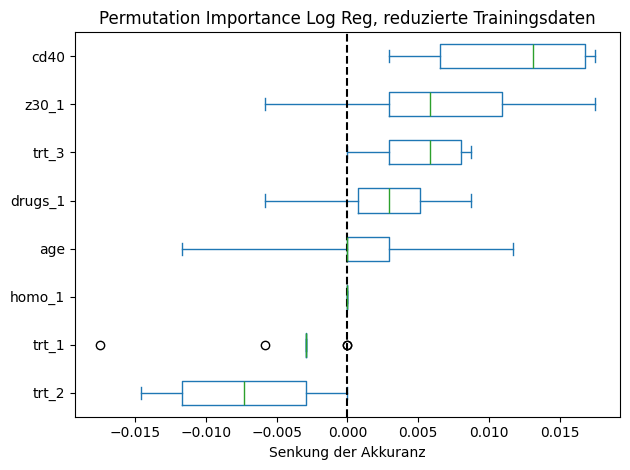

In [25]:
best_logreg.fit(X_train2, y_train2)
y_pred31 = best_logreg.predict(X_test2)
accuracy31 = accuracy_score(y_test2, y_pred31)
print("LogReg",classification_report(y_pred31, y_test2))
print(f"Akkuranz Log Reg, Trainingsdaten:, {accuracy31:3f}")

perm_logreg_train2 = permutation_importance(best_logreg, X_test2, y_test2, random_state=42, n_repeats=10, n_jobs=2)

feature_names21 = X_train2.columns
features = np.array(feature_names21)

sorted_importances_idx = perm_logreg_train2.importances_mean.argsort()
importances21 = pd.DataFrame(
    perm_logreg_train2.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances21.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importance Log Reg, reduzierte Trainingsdaten")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Senkung der Akkuranz")
ax.figure.tight_layout()

In [26]:
features

array(['cd40', 'trt_1', 'trt_2', 'trt_3', 'z30_1', 'strat_2', 'strat_3',
       'symptom_1'], dtype=object)

# Evaluation des Modells auf finalen Testdaten

In [27]:
X_fintrain.columns

Index(['age', 'cd40', 'trt_1', 'trt_2', 'trt_3', 'homo_1', 'drugs_1', 'z30_1',
       'gender_1', 'strat_2', 'strat_3', 'symptom_1', 'hemo_1', 'race_1',
       'ecog_1'],
      dtype='object')

In [28]:
# unnütze Features aus dem Haupt-Trainingsdatensatz entfernen
X_ftrain=X_fintrain.drop(['age', 'homo_1', 'drugs_1', 'gender_1', 'hemo_1', 'race_1', 'ecog_1'],axis=1)
X_ftest=X_fintest.drop(['age', 'homo_1', 'drugs_1', 'gender_1', 'hemo_1', 'race_1', 'ecog_1'],axis=1)
y_ftrain = y_fintrain.copy()
y_ftest = y_fintest.copy()

In [29]:
# MonMaxScaler nur transformieren auf Testdaten
X_ftrain['cd40'] = mscaler.transform(X_ftrain['cd40'].to_numpy().reshape(-1,1))
X_ftest['cd40'] = mscaler.transform(X_ftest['cd40'].to_numpy().reshape(-1,1))

In [30]:
# LogReg Modell auf Testdaten, Modell-Performance Parameter

lrc = best_logreg.fit(X_ftrain, y_ftrain)
y_pred_fin = best_logreg.predict(X_ftest)
accuracy_fin = accuracy_score(y_ftest, y_pred_fin)
print("LogReg Testdaten",classification_report(y_pred_fin, y_ftest))

LogReg Testdaten               precision    recall  f1-score   support

           0       0.97      0.77      0.86       411
           1       0.07      0.41      0.12        17

    accuracy                           0.76       428
   macro avg       0.52      0.59      0.49       428
weighted avg       0.93      0.76      0.83       428



97% des Target = 0 und 7% des Target = 1 werden richtig vorhergesagt.

77% des vorhergesagten Target = 0 und 41% des vorhergesagten Target = 1 sind es tatsächlich.

In 76% der Fälle macht das Modell eine korrekte Vorhersage.

In [ ]:
import pickle

#os
#os.getcwd()
#os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))


# Modell speichern
file_to_write = open("data/models/log_reg_model.pickle", 'wb')
pickle.dump(lrc, file_to_write)

# Modell laden
file_to_open = open("data/models/log_reg_model.pickle", 'rb')
trained_model = pickle.load(file_to_open)
file_to_open.close()

# noch probs mit dem Pfad ... 

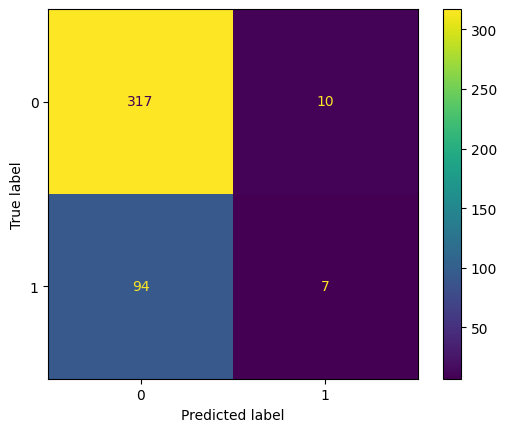

In [33]:
# onfusion matrix für precision und recall für LogReg auf Testdaten
cm_fin = confusion_matrix(y_ftest, y_pred_fin)

ConfusionMatrixDisplay(cm_fin).plot();

In [34]:
#Accuracy im Traings- und Testdatensatz
# Gibt es Over- bzw. Underfit? Wie gut wurde gesplittet?

print(f"Akkuranz Log Reg, finale Trainingsdaten:, {best_logreg.score(X_ftrain, y_ftrain):3f}")
print(f"Akkuranz Log Reg, finale Testdaten:, {best_logreg.score(X_ftest, y_fintest):3f}")

Akkuranz Log Reg, finale Trainingsdaten:, 0.766803
Akkuranz Log Reg, finale Testdaten:, 0.757009


Es liegt immernoch ein Overfitting vor. Allerdings fällt es weitaus geringer aus.  

# Interpretation

feature importance, Aussagekraft der Prediction.

## Feature Importance

[[-0.24815242 -0.32377506 -0.2858626  -0.19572406  0.19217387  0.16707867
   0.          0.02937612]]


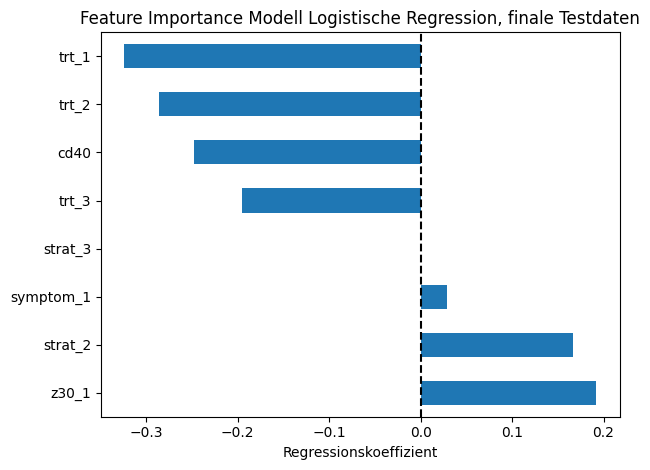

In [35]:
lrc.fit(X_ftest / np.std(X_ftest, 0), y_ftest)
print(lrc.coef_) #

ax=pd.Series((lrc.coef_[0]), index=features).nlargest(15).plot(kind='barh')
ax.set_title("Feature Importance Modell Logistische Regression, finale Testdaten")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Regressionskoeffizient")
ax.figure.tight_layout()

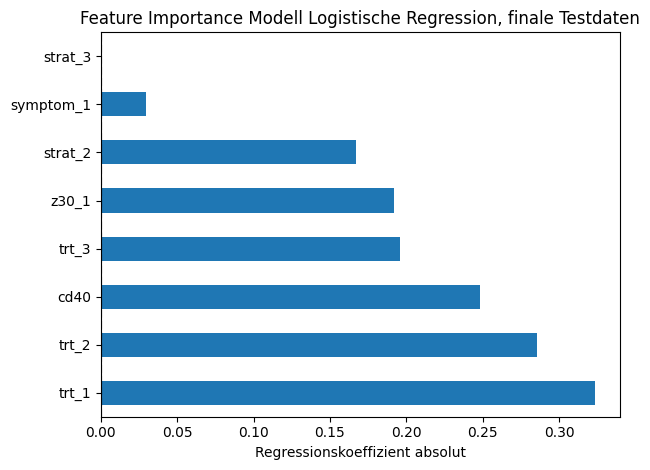

In [36]:
ax=pd.Series(abs((lrc.coef_[0])), index=features).nlargest(15).plot(kind='barh')
ax.set_title("Feature Importance Modell Logistische Regression, finale Testdaten")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Regressionskoeffizient absolut")
ax.figure.tight_layout()

Die Visualisierung zeigt, wie wichtigt das jeweilige Feature für die Modell-Vorhersage des Targets ist. Das Log Reg Modell - als Whitebox-Modell - lässt sich direkt über seine Koeffizienten interpretieren. 